<a href="https://colab.research.google.com/github/AEInha/Linear-Algebra/blob/main/Formation_flight_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Formation flight

$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
$$

__<div style="text-align: right"> ASE7030: Convex Optimization, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_


<br>

You are operating a team of $K$ identical drones; one leader and $K-1$ follower drones, for which you are trying to design optimal formation flight trajectories.

Vehicle $k$'s dynamical behaviour in horizontal plane can be described by
$$
\begin{aligned}
  x^{(k)}_{t+1} &= Ax^{(k)}_t + Bu^{(k)}_t
\end{aligned}
$$
where the state vector $x^{(k)}_t \in \R^4$ consists of two positions ($p^{(k)}_t\in\R^2$) and two velocities ($v^{(k)}_t\in\R^2$). The vehicle's control $u^{(k)}_t\in\R^2$ is acceleration control for the two axes. Then the following matrices describe the above dynamics.
$$
A = \bmat{
1 & 0 & \left(1-0.5\gamma\Delta t\right)\Delta t & 0 \\
0 & 1 & 0 & \left(1-0.5\gamma\Delta t\right)\Delta t \\
0 & 0 & 1-\gamma\Delta t & 0 \\
0 & 0 & 0 & 1-\gamma\Delta t
} \\
B = \bmat{
0.5\Delta t^2 & 0 \\
0 & 0.5\Delta t^2 \\
\Delta t & 0 \\
0 & \Delta t
}
$$

We consider $t\in \{0,\dots,N-1\}$ with $N=1000$ and $\Delta t=0.02$, and we further assume that all the vehicles are (dynamically) identical, that is, they have the same $A$ and $B$.




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as ssp
import scipy.sparse.linalg as sla

n = 1000 # number of timesteps
T = 20 # time will vary from 0 to T with step delt
ts = np.linspace(0,T,n+1)
delt = T/n
gamma = .05 # damping, 0 is no damping

A = np.zeros((4,4))
B = np.zeros((4,2))

A[0,0] = 1
A[1,1] = 1
A[0,2] = (1-gamma*delt/2)*delt
A[1,3] = (1-gamma*delt/2)*delt
A[2,2] = 1 - gamma*delt
A[3,3] = 1 - gamma*delt

B[0,0] = delt**2/2
B[1,1] = delt**2/2
B[2,0] = delt
B[3,1] = delt

<br>

We assume that the vehicles are initially at random position with random velocity. You can assume that the random variables are normally distributed.

In [2]:
K = 6     # 6 drones

np.random.seed(1)

p_0 = np.random.randn(2,K)*2    # initial positions
v_0 = np.random.randn(2,K)      # initial velocities

<br>

The initial position and the velocity is visualized below:

Initial position:
 [[ 3.24869073 -1.22351283 -1.0563435  -2.14593724  1.73081526 -4.60307739]
 [ 3.48962353 -1.5224138   0.63807819 -0.49874075  2.92421587 -4.12028142]]
Initial velocity:
 [[-0.3224172  -0.38405435  1.13376944 -1.09989127 -0.17242821 -0.87785842]
 [ 0.04221375  0.58281521 -1.10061918  1.14472371  0.90159072  0.50249434]]


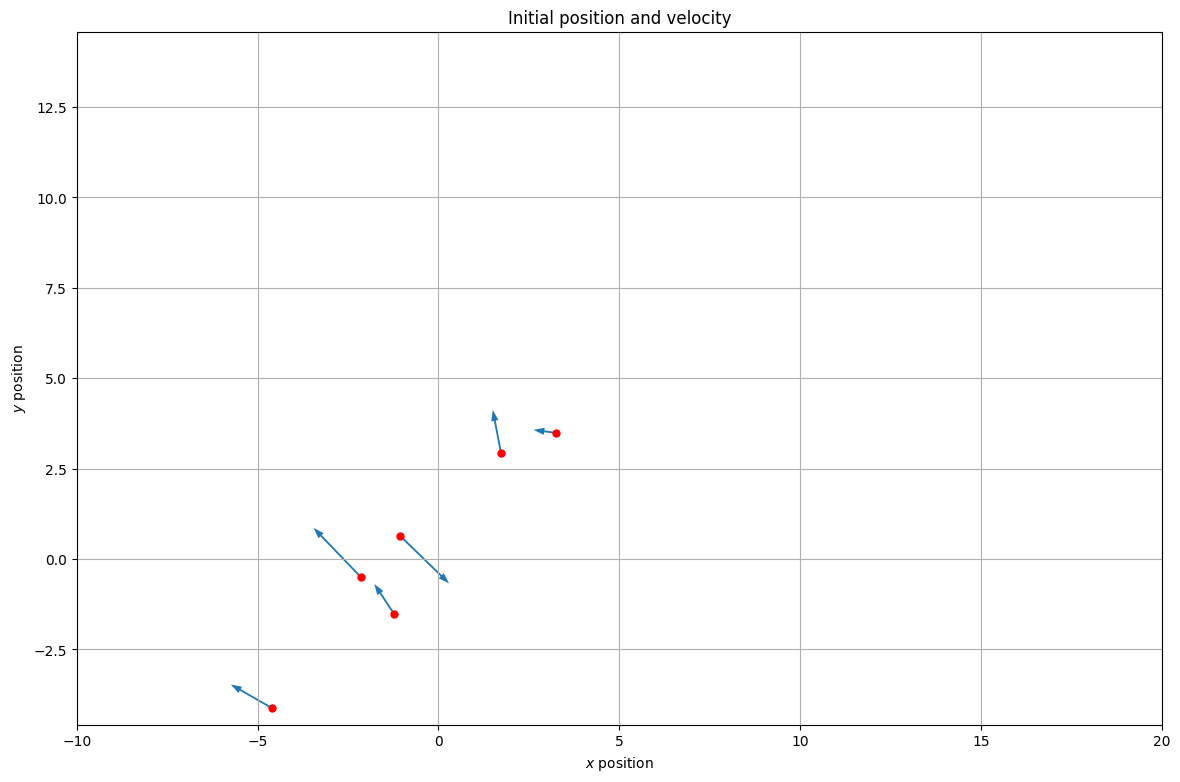

In [3]:
print("Initial position:\n", p_0)
print("Initial velocity:\n", v_0)

plt.figure(figsize=(14,9), dpi=100)
for i in range(K):
  plt.plot(p_0[0,i], p_0[1,i], 'ro', markersize=5)
  plt.arrow(p_0[0,i], p_0[1,i], v_0[0,i], v_0[1,i], head_width=0.2, width=0.05, ec='none')
plt.title('Initial position and velocity')
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.xlim(-10,20)
plt.ylim(-5,15)
plt.grid()
plt.show()

<br>

You are required to find the minimum energy formation trajectory that achieves the following formation at $t=N$.

- The position of the followers (vehicle $2,\dots,K$) are defined relative to the leader. For example, equispaced circular formation around the leader can be speficied as follows.
$$
  p^{(k)}_N = p^{(1)}_N + r_\text{formation}\bmat{\sin\frac{2\pi (k-1)}{(K-1)} \\ \cos\frac{2\pi (k-1)}{(K-1)} }
$$
- The velocity of the followers (vehicle $2,\dots,K$) are also defined relative to the leader. For example, the relative velocities of the followers heading towards the leader can be specified as follows.
$$
  v^{(k)}_N = v^{(1)}_N - v_\text{formation}\bmat{\sin\frac{2\pi (k-1)}{(K-1)} \\ \cos\frac{2\pi (k-1)}{(K-1)} }
$$

Note that **the leader's final position and the velocity, $p^{(1)}_N$ and $v^{(1)}_N$, are unconstrained.**

<br>

Find the optimal formation flight trajectory by solving
$$
\begin{aligned}
  \underset{u^{(1)}_0,\dots,u^{(1)}_{N-1},\dots,u^{(K)}_0,\dots,u^{(K)}_{N-1}}{\minimize} \quad & \sum_{k=1}^K\sum_{t=0}^{N-1} \|u^{(k)}_t\|^2
\end{aligned}
$$
under the prementioned formation flight constraints.


In [4]:
r_formation = 1    # the radius of the formation circle
v_formation = 2    # the speed difference between the leader and the followers

<br>

_Hint: Define your state variable as the $4K$-vector containing the states of all drones,
$$
  x_t = \bmat{x_t^{(1)} \\ \vdots \\ x_t^{(K)}}
$$
and the control variable as the $2K$-vector containing the controls of all drones:
$$
  u_t = \bmat{u_t^{(1)} \\ \vdots \\ u_t^{(K)}}
$$
Expressing the linear dynamics and the optimization problem in terms of these will help._


(24, 12000)


<Figure size 1400x900 with 0 Axes>

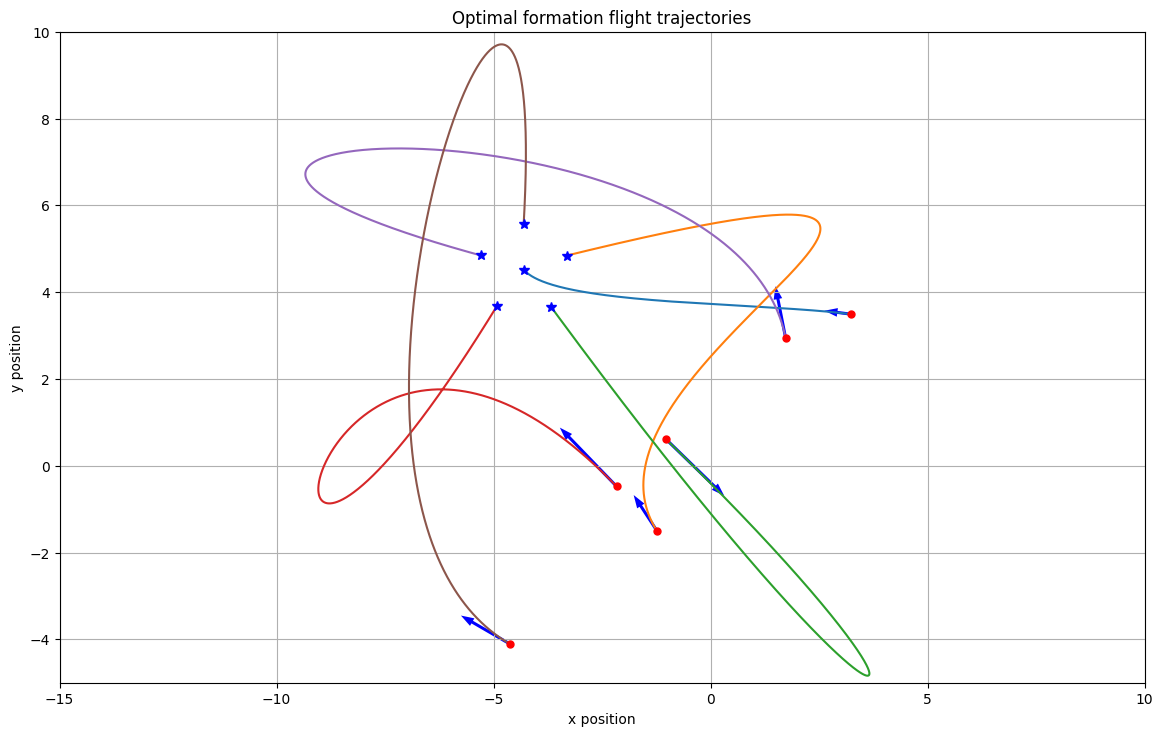

In [23]:

A_total = np.zeros([len(A)*K,len(A)*K])
for i in range(K):
  A_total[4*i:4*(i+1),4*i:4*(i+1)] = A
B_total = np.zeros([len(B)*K,len(B[0])*K])
for i in range(K):
  B_total[4*i:4*(i+1),2*i:2*(i+1)] = B

A_total_1000 = np.linalg.matrix_power(A_total,n)
B_total_1000 = np.zeros([4*K,2*K*n])
print(np.shape(B_total_1000))
for i in range(n):
  B_total_1000[:,2*K*i:2*K*(i+1)] = np.linalg.matrix_power(A_total,n-i)@B_total
C = np.zeros([4*K,4])
for i in range(K):
  C[4*i:4*(i+1),:] = np.eye(4)

D = np.zeros(4*K)
for i in range(1,K):
  D[4*i] = r_formation  * np.sin(2*np.pi*(i) /(K-1))
  D[4*i+1] = r_formation  * np.cos(2*np.pi*(i) /(K-1))
  D[4*i+2] = -v_formation  * np.sin(2*np.pi*(i) /(K-1))
  D[4*i+3] = -v_formation  * np.cos(2*np.pi*(i) /(K-1))

x0 = np.zeros(K*4)
for i in range(K):
  x0[4*i:4*i+2] = p_0[:,i]
  x0[4*i+2:4*(i+1)] = v_0[:,i]


A_new = np.linalg.pinv(B_total_1000)@C

B_new = np.linalg.pinv(B_total_1000)@(D - A_total_1000@x0)

x_fin = np.linalg.pinv(A_new)@(-B_new)

X_1000 = C @ x_fin + D

U   = np.linalg.lstsq(B_total_1000,X_1000 - np.linalg.matrix_power(A_total,n)@x0, rcond=0)[0]


plt.figure(figsize=(14,9), dpi=100)
plt.figure(figsize=(14, 9),dpi = 100)
for k in range(K):
  x_drone0 = np.hstack([p_0[:,k],v_0[:,k]])
  drone_x = np.zeros(1000)
  drone_y = np.zeros(1000)
  drone_v_x = np.zeros(1000)
  drone_v_y = np.zeros(1000)
  for i in range(n):
    u=U[2*K*i+2*k:2*K*i+2*(k+1)]
    x_drone0 = A@x_drone0 + B@u
    drone_x[i] = x_drone0[0]
    drone_y[i] = x_drone0[1]
    drone_v_x[i] = x_drone0[2]
    drone_v_y[i] = x_drone0[3]
  plt.plot(drone_x,drone_y)
  plt.plot(drone_x[0], drone_y[0], 'o', markersize=5, color = "red")
  plt.arrow(drone_x[0], drone_y[0], drone_v_x[0], drone_v_y[0], head_width=0.2, width=0.07, color = "blue", ec='none')
  plt.plot(drone_x[-1], drone_y[-1], '*', markersize=7, label='Target position',color = "blue")
plt.title("Optimal formation flight trajectories")
plt.xlabel("x position")
plt.ylabel("y position")
plt.xlim(-15,10)
plt.ylim(-5,10)
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')

Your results should look something like the above picture.